In [1]:
import fastai
from fastai import *
from fastai.text import * 

In [2]:
import pandas as pd
df = pd.read_csv("combined_data.csv")
df.head()

,id,text,label
0,4330,nen á vist bolest vztek smutek zmatek osam ě l...,2
1,41616,@nehantics Haan yaar neha 😔😔 kab karega woh po...,2
2,6648,@RahulGandhi television media congress ke liye...,1
3,2512,@AmitShah @narendramodi All India me nrc lagu ...,0
4,610,@Nehr _ who @TypoMantri @anjanaomkashyap Pagal...,2


In [3]:
df = df[["label", "text"]]
# df = df.rename({'label':'target','text':text},inplace=True) # renaming cols
df.head()

,label,text
0,2,nen á vist bolest vztek smutek zmatek osam ě l...
1,2,@nehantics Haan yaar neha 😔😔 kab karega woh po...
2,1,@RahulGandhi television media congress ke liye...
3,0,@AmitShah @narendramodi All India me nrc lagu ...
4,2,@Nehr _ who @TypoMantri @anjanaomkashyap Pagal...


In [4]:
from sklearn.model_selection import train_test_split
df_trn, df_test = train_test_split(df, stratify = df['label'], test_size = 0.15, random_state = 11) 
df_trn, df_val = train_test_split(df_trn, stratify = df_trn['label'], test_size = 0.15,
                                  random_state = 11)

In [6]:
bs=32 # was 48 
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")
data_lm.save( './data_lm.pkl') # saving as a back stop
data_lm = load_data('./','data_lm.pkl', bs=bs)

learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3) 

In [9]:
learn.summary()

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [70, 400]            0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
Linear               [70, 30536]          12,244,936 True      
______________________________________________________________________
RNNDropout           [70, 400]            0          False     
______________________________________________________________________

Total params: 12,244,936
Total trainable params: 12,244,936
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss fu

In [10]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3) 
learn.lr_find()
learn.recorder.plot(skip_end=15)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

In [5]:
bs=32 # was 48 
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")
data_lm.save( './data_lm.pkl') # saving as a back stop

In [6]:
data_lm = load_data('./','data_lm.pkl', bs=bs)

In [7]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3) 

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,6.772205,5.960392,0.173298,26:31
1,6.095018,5.545704,0.208501,26:26
2,5.708511,5.237559,0.231975,25:51
3,5.279060,4.962680,0.253385,25:15
4,4.836950,4.730321,0.273214,24:58
5,4.394347,4.523580,0.288514,25:07
6,3.945586,4.355494,0.302520,25:12
7,3.529063,4.214273,0.318090,25:50
8,3.225629,4.091036,0.331873,25:20
9,2.998251,4.009192,0.341695,25:23


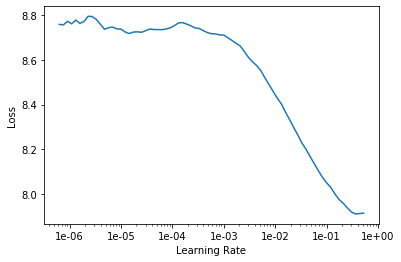

In [8]:
bs=32 # was 48 
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")
data_lm.save( './data_lm.pkl') # saving as a back stop
data_lm = load_data('./','data_lm.pkl', bs=bs)

learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3) 

learn.lr_find()
learn.recorder.plot(skip_end=15)
learn.fit_one_cycle(50, 1e-2, moms=(0.8,0.7)) 

In [9]:
learn.unfreeze() # unfreeze all layers to compete the training of full model
learn.fit_one_cycle(20, 1e-3, moms=(0.8,0.7)) # do a full 10 epochs this time around

learn.save_encoder('fine_tuned_enc')

epoch,train_loss,valid_loss,accuracy,time
0,1.145349,3.055035,0.561077,26:53
1,1.094514,3.016288,0.568471,26:42
2,1.067507,2.975821,0.577548,26:48
3,1.053232,2.940648,0.588700,26:28
4,1.055632,2.899907,0.597554,26:40
5,0.982112,2.856500,0.610045,26:47
6,0.928938,2.826004,0.621977,26:40
7,0.880337,2.792054,0.634328,26:42
8,0.824988,2.762400,0.643155,26:35
9,0.765679,2.763195,0.652251,26:43


In [12]:
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, test_df=df_test, vocab=data_lm.train_ds.vocab, bs=bs)
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

In [13]:
learn.summary()

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [11, 400]            0          False     
______________________________________________________________________
RNNDropout           [11, 1152]           0          False     
______________________________________________________________________
RNNDropout           [11, 1152]           0          False     
______________________________________________________________________
BatchNorm1d          [1200]               2,400      True      
______________________________________________________________________
Dropout              [1200]               0          False     
______________________________________________________________________
Linear               [50]                 60,050     True      
______________________________________________________________________
ReLU                 [50]                 0          False     
________________________________________________

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,0.940902,0.880180,0.560334,18:13
1,0.921318,0.868306,0.582343,18:04
2,0.907256,0.857028,0.581078,18:51
3,0.879184,0.839716,0.594991,19:37
4,0.882636,0.840665,0.589426,20:12


epoch,train_loss,valid_loss,accuracy,time
0,0.891650,0.820968,0.608146,19:21
1,0.834628,0.787457,0.634455,19:48


epoch,train_loss,valid_loss,accuracy,time
0,0.801387,0.738662,0.677207,21:24
1,0.659284,0.658925,0.726790,22:31


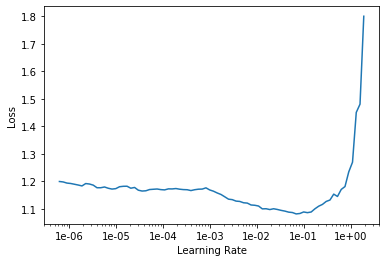

In [11]:
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, test_df=df_test, vocab=data_lm.train_ds.vocab, bs=bs)
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc') # load th encoder from the LM
learn.lr_find() # find an LR
learn.recorder.plot()
# Training
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))  # you can of course train more, Jeremy promises its hard to over fit here :D
learn.freeze_to(-2) # unfreeze last 2 layers
learn.fit_one_cycle(2, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
learn.freeze_to(-3) # unfreeze last 3 layers
learn.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

In [13]:
# finally
learn.unfreeze() # unfreze all
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

# learn.predict("Random Piece of text... Remember the GIGO rule..? well that applies to AI and ML too")

epoch,train_loss,valid_loss,accuracy,time
0,0.472339,0.570601,0.774855,24:04
1,0.465664,0.536399,0.796104,31:16
2,0.397670,0.535065,0.791298,28:20


In [14]:
learn.save_encoder('fine_tuned_enc1')

In [38]:
x = learn.predict("sir local police station pe complaint krne par bi sunwai nhi hai .. mene 5 may 2019 Ko complaint karwai")

In [39]:
str(x[0])[-1]

'2'

In [24]:
import pandas as pd

In [31]:
df = pd.read_csv("Preprocessed_data/Hindi_test_unalbelled_conll_updated.csv")

In [32]:
row = [['id', 'label']]
for i in range(len(df)):
    if i%100==0:
        print(i)
    text = df.iloc[i, 1]
    l = learn.predict(text)
    
    row.append([df.iloc[i, 0], str(l[0])[-1]])

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


In [36]:
row.append([25183, '1'])

In [37]:
import csv
with open('Preprocessed_data/test_labels.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(row)

In [34]:
learn.predict("@BhadasManKi @mithleshkumarmi @Kiranja34522516 @BJPindia @sherryontopp Chutiya h madarchod Sabse harami h ye thuk k ")

(Category 1, tensor(1), tensor([0.0576, 0.9292, 0.0131]))

In [35]:
row[-1]

[25435, '2']

In [40]:
f=open("test_labels_sorted.txt","r")
s=f.read()
lst=s.split("\n")

In [41]:
len(lst)

3001